In [89]:
import pandas as pd
import matplotlib.pyplot as plt

In [90]:
# Read in data
accounts = pd.read_csv("../Resources/accounts.csv")
ast = pd.read_csv("../Resources/account_state_transitions.csv")
groups = pd.read_csv("../Resources/groups.csv")
payments = pd.read_csv("../Resources/payments.csv")

## How long does it typically take Account holders to repay the unlock price as a % of the nominal loan term?

In [91]:
# Filter dataframes
unlocked_df = ast[ast['to_state']=='UNLOCKED']
created_df = ast[ast['from_state']=='CREATED']

# Select ids of unlocked accounts
unlocked_accounts = [account for account in unlocked_df['account_id']]

In [92]:
# Merge and limit columns
created_unlocked = pd.merge(left=unlocked_df,right=created_df,how="inner",left_on='account_id',right_on='account_id')
created_unlocked = created_unlocked[['account_id','started_when_y','started_when_x']]

In [93]:
# Rename columns
created_unlocked = created_unlocked.rename(columns={
    'started_when_y':'date_created',
    'started_when_x':'date_unlock'
})

# created_unlocked.head()

In [94]:
# Convert to datetime
created_unlocked['date_unlock'] = pd.to_datetime(created_unlocked['date_unlock'])
created_unlocked['date_created'] = pd.to_datetime(created_unlocked['date_created'])

In [95]:
# Add calculated column
created_unlocked['time_difference'] = created_unlocked['date_unlock'] - created_unlocked['date_created']
# created_unlocked.head()

In [96]:
# Count of payments
payments_ct = payments.groupby('account_id', as_index=False)['id'].count()

# Rename column
payments_ct = payments_ct.rename(columns={'id':'num_payments'})
# payments_ct.head()

In [97]:
# Filter dataframe for 'unlocked' accounts
payments_ct_unlocked = payments_ct[payments_ct['account_id'].isin(unlocked_accounts)]
# payments_ct_unlocked.head()

In [98]:
created_unlocked = pd.merge(left=created_unlocked,right=payments_ct_unlocked,how='outer',left_on='account_id',right_on='account_id')
# created_unlocked.head()

In [99]:
# Filter accounts df by 'unlocked_accounts'
accounts_filtered = accounts[accounts['id'].isin(unlocked_accounts)]
# accounts_filtered.head()

In [100]:
# Add calculated column
# "loan term" = number of payments to reach price_unlock if only paying the minimum amount
groups['loan_term'] = (groups['price_unlock'] - groups['price_upfront']) / groups['minimum_payment']

In [101]:
# Merge accounts_filtered with groups
acct_group_merge = pd.merge(left=accounts_filtered, right=groups, how='outer',left_on='group_id',right_on='id')
acct_group_merge = acct_group_merge[['id_x','loan_term']]
acct_group_merge = acct_group_merge.rename(columns={'id_x':'account_id'})
# acct_group_merge.head()

In [102]:
# Merge 'created_unlocked' and 'acct_group_merge' dataframes
pct_loan_term = pd.merge(left=created_unlocked, right=acct_group_merge,how='inner',left_on='account_id',right_on='account_id')
# pct_loan_term.head()

In [103]:
# Add calculated column
pct_loan_term['pct_loan_term_%'] = (pct_loan_term['num_payments']/pct_loan_term['loan_term'])*100

# Format 'pct_loan_term' as a percentage
# pct_loan_term['pct_loan_term'] = pct_loan_term['pct_loan_term'].map("{:.0%}".format)
pct_loan_term.head(10)

,account_id,date_created,date_unlock,time_difference,num_payments,loan_term,pct_loan_term_%
0,2,2019-11-06 05:49:39.571392,2020-02-24 02:00:21.571392,109 days 20:10:42,18,100.0,18.0
1,4,2019-12-11 03:18:53.571392,2020-02-25 04:28:59.571392,76 days 01:10:06,13,100.0,13.0
2,6,2019-09-29 13:04:45.571392,2020-02-20 18:54:47.571392,144 days 05:50:02,23,100.0,23.0
3,9,2019-10-10 12:49:10.571392,2020-03-04 07:45:50.571392,145 days 18:56:40,23,100.0,23.0
4,10,2019-12-15 03:38:31.571392,2020-02-21 15:48:49.571392,68 days 12:10:18,12,100.0,12.0
5,11,2019-09-22 00:50:52.571392,2020-02-22 10:21:48.571392,153 days 09:30:56,24,100.0,24.0
6,12,2019-10-03 09:22:40.571392,2020-03-03 13:35:30.571392,152 days 04:12:50,24,100.0,24.0
7,14,2019-07-14 10:38:51.571392,2020-02-29 01:21:59.571392,229 days 14:43:08,35,100.0,35.0
8,16,2019-06-27 01:35:05.571392,2020-03-02 21:13:29.571392,249 days 19:38:24,38,100.0,38.0
9,18,2019-10-03 09:21:49.571392,2020-03-04 14:41:14.571392,153 days 05:19:25,24,100.0,24.0


## Visualize

In [107]:
# Select data to visualize
data_viz = pct_loan_term.groupby('pct_loan_term_%', as_index=False)['account_id'].count()

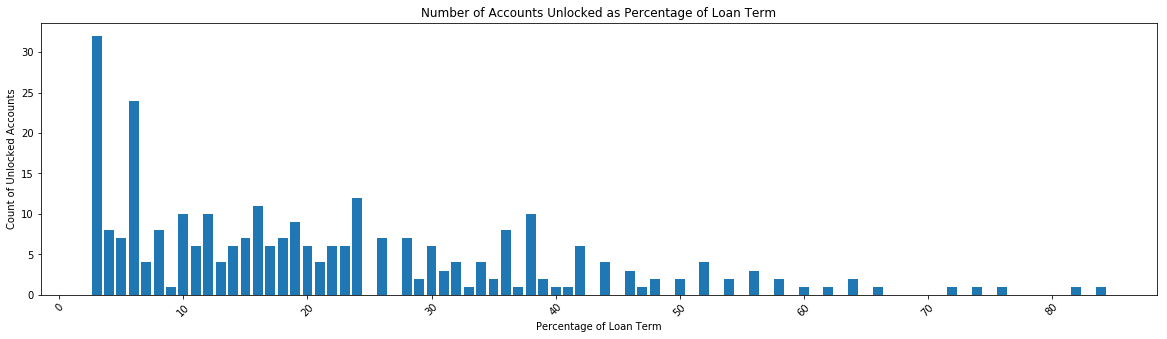

In [108]:
# Create plot
plt.figure(figsize=(20, 5))
plt.bar(data_viz.iloc[:,0],data_viz.iloc[:,1])
plt.title("Number of Accounts Unlocked as Percentage of Loan Term")
plt.xlabel("Percentage of Loan Term")
plt.xticks(rotation=45)
plt.ylabel("Count of Unlocked Accounts")
plt.show()

Most loans are bad back before 50% of the loan term